In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import (GridSearchCV, ParameterGrid,
                                     RandomizedSearchCV)
from sklearn.metrics import fbeta_score, make_scorer
from imblearn.pipeline import Pipeline as Pipeline_imb
from imblearn.over_sampling import SMOTENC, RandomOverSampler
from tools import (Modelisation, datasets, SearchCV, restauration_CV, 
                   graph_2scores_CV, graph_3scores_CV, graph_param_CV, 
                   best_score_CV)

t = time.time()

In [2]:
df = pd.read_csv('data/df_train_prepro.csv').sample(frac=1)
df.shape

(1610494, 48)

**Définition des variables quantitatives, des variables catégorielles et des datasets :**

In [3]:
datasets_df = datasets(df)
X_quant = datasets_df['X_quant']
X_cat = datasets_df['X_cat']
X = datasets_df['X']
y = datasets_df['y']

Columns_quant :


['contextid',
 'campaignctrlast24h',
 'dayssincelastvisitdouble',
 'ltf_nbglobaldisplay_4w',
 'ltf_nbpartnerdisplayssincelastclick',
 'ltf_nbpartnerdisplay_90d',
 'ltf_nbpartnerclick_90d',
 'ltf_nbpartnersales_90d',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'nbdisplayglobalapprox_1d_sum_xdevice',
 'display_size',
 'zonecostineuro']


Columns_cat :


['display_env',
 'target_env',
 'campaignscenario',
 'campaignvertical',
 'is_interstitial',
 'device_type',
 'hour',
 'weekday']


Nombre de variables pour X_quant : 13



Index(['contextid', 'campaignctrlast24h', 'dayssincelastvisitdouble',
       'ltf_nbglobaldisplay_4w', 'ltf_nbpartnerdisplayssincelastclick',
       'ltf_nbpartnerdisplay_90d', 'ltf_nbpartnerclick_90d',
       'ltf_nbpartnersales_90d', 'nbdayssincelastclick', 'nbdisplay_1hour',
       'nbdisplayglobalapprox_1d_sum_xdevice', 'display_size',
       'zonecostineuro'],
      dtype='object')


Nombre de variables pour X_cat : 50



Index(['display_env_app_ios', 'display_env_other', 'display_env_web',
       'target_env_2', 'campaignscenario_5', 'campaignscenario_6',
       'campaignscenario_11', 'campaignscenario_12', 'campaignscenario_13',
       'campaignscenario_17', 'campaignvertical_20.0', 'campaignvertical_23.0',
       'campaignvertical_129.0', 'campaignvertical_200002.0',
       'is_interstitial_True', 'device_type_Desktop',
       'device_type_Desktop - Safari', 'device_type_Mobile - Other',
       'device_type_Unknown', 'device_type_iPad', 'device_type_iPhone',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday'],
      dtype='object')


Nombre de variables pour X : 63


# Decision tree
## Variables quantitatives

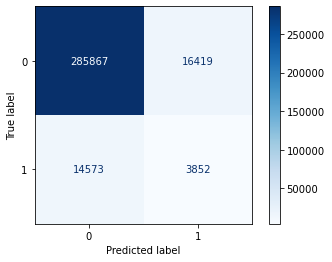

f1 : 0.1991
f3 : 0.2070
f5 : 0.2083
recall : 0.2091
negative predictive value : 0.9515
precision : 0.1900
roc_auc : 0.5774
training time : 19.702s
prediction time : 0.169s


In [4]:
m = Modelisation(X_quant, y, DecisionTreeClassifier())
m.show_conf_matrix()
m.show_metrics_score()

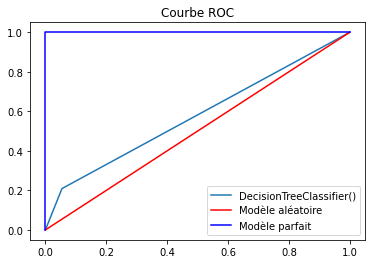

In [5]:
m.show_ROC()

In [6]:
m.show_attributes()

max_depth : 50
n_leaves : 91618
node_count : 183235


/home/headless/work/statapp/tools.py:168: RuntimeWarning: invalid value encountered in long_scalars
  Precision = TP / (TP + FP)


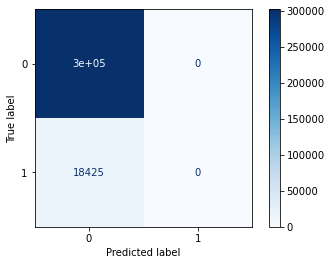

f1 : nan
f3 : nan
f5 : nan
recall : 0.0000
negative predictive value : 0.9425
precision : nan
roc_auc : 0.7404
training time : 2.407s
prediction time : 0.034s


In [7]:
m = Modelisation(X_quant, y, DecisionTreeClassifier(max_depth=2))
m.show_conf_matrix()
m.show_metrics_score()

In [8]:
m.show_attributes()

max_depth : 2
n_leaves : 4
node_count : 7


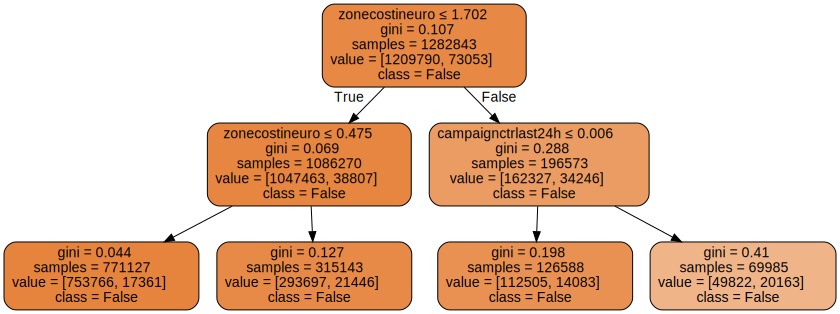

In [9]:
m.plot_tree()

## Variables catégorielles

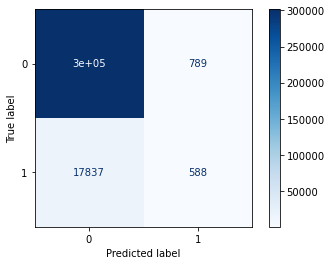

f1 : 0.0594
f3 : 0.0352
f5 : 0.0331
recall : 0.0319
negative predictive value : 0.9441
precision : 0.4270
roc_auc : 0.6525
training time : 12.487s
prediction time : 0.141s


In [10]:
m = Modelisation(X_cat, y, DecisionTreeClassifier())
m.show_conf_matrix()
m.show_metrics_score()

In [11]:
m.show_attributes()

max_depth : 47
n_leaves : 19666
node_count : 39331


## Variables quantitatives + catégorielles

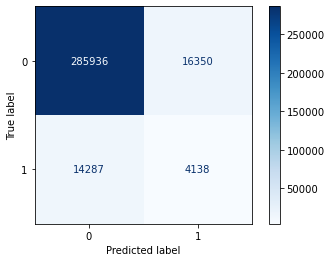

f1 : 0.2127
f3 : 0.2221
f5 : 0.2236
recall : 0.2246
negative predictive value : 0.9524
precision : 0.2020
roc_auc : 0.5852
training time : 36.31s
prediction time : 0.265s


In [12]:
m = Modelisation(X, y, DecisionTreeClassifier())
m.show_conf_matrix()
m.show_metrics_score()

In [13]:
m.show_attributes()

max_depth : 53
n_leaves : 87537
node_count : 175073


# Random Forest

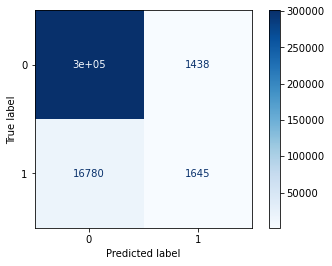

f1 : 0.1530
f3 : 0.0974
f5 : 0.0922
recall : 0.0893
negative predictive value : 0.9472
precision : 0.5336
roc_auc : 0.7345
training time : 5.55s
prediction time : 0.314s


In [14]:
m = Modelisation(X, y, RandomForestClassifier(n_estimators=10, n_jobs=-1))
m.show_conf_matrix()
m.show_metrics_score()

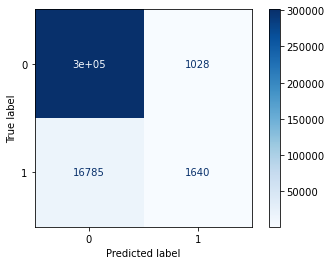

f1 : 0.1555
f3 : 0.0973
f5 : 0.0920
recall : 0.0890
negative predictive value : 0.9472
precision : 0.6147
roc_auc : 0.8125
training time : 28.367s
prediction time : 0.944s


In [15]:
m = Modelisation(X, y, RandomForestClassifier(n_estimators=100, n_jobs=-1))
m.show_conf_matrix()
m.show_metrics_score()

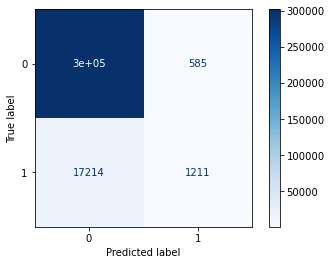

f1 : 0.1198
f3 : 0.0722
f5 : 0.0681
recall : 0.0657
negative predictive value : 0.9460
precision : 0.6743
roc_auc : 0.8324
training time : 27.362s
prediction time : 0.653s


In [16]:
m = Modelisation(X, y, RandomForestClassifier(min_samples_leaf=15, n_estimators=100, n_jobs=-1))
m.show_conf_matrix()
m.show_metrics_score()

## Tuning des hyperparamètres avec GridSearchCV

In [17]:
model = RandomForestClassifier()

cv_params = {
        'bootstrap': [False, True],
        'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
        'max_features': ['sqrt', 'log2'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [50, 100, 200, 400, 600, 800, 1000, 1500],
        "class_weight": [None, 'balanced', {0:1, 1:2}, {0:1, 1:4}, {0:1, 1:8}, {0:1, 1:10}, {0:1, 1:12}, {0:1, 1:14}, {0:1, 1:16.5}, {0:1, 1:32}] 
}

scoring = {'recall': 'recall',
           'precision': 'precision',
           'f1': 'f1',
           'f3': make_scorer(fbeta_score, beta=3),
           'f5': make_scorer(fbeta_score, beta=5)
          }

print(len(ParameterGrid(cv_params)))

31680


In [18]:
# SearchCV(model, cv_params, data_frac=0.02, random=True, n_iter=5000, scoring=scoring, random_state=1234, n_jobs=28)

In [19]:
dico, results = restauration_CV('Forest_CV_Randomized5000_31680_0.02')

model : RandomForestClassifier()
model_name : Forest
type : RandomizedSearchCV
len_grid : 31680
n_iter : 5000
data_frac : 0.02
temps : 6h, 29min, 37.105s
n_jobs : 28
params : {'bootstrap': [False, True], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 5, 10], 'n_estimators': [50, 100, 200, 400, 600, 800, 1000, 1500], 'class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 1, 1: 4}, {0: 1, 1: 8}, {0: 1, 1: 10}, {0: 1, 1: 12}, {0: 1, 1: 14}, {0: 1, 1: 16.5}, {0: 1, 1: 32}]}
scoring : {'recall': 'recall', 'precision': 'precision', 'f1': 'f1', 'f3': make_scorer(fbeta_score, beta=3), 'f5': make_scorer(fbeta_score, beta=5)}


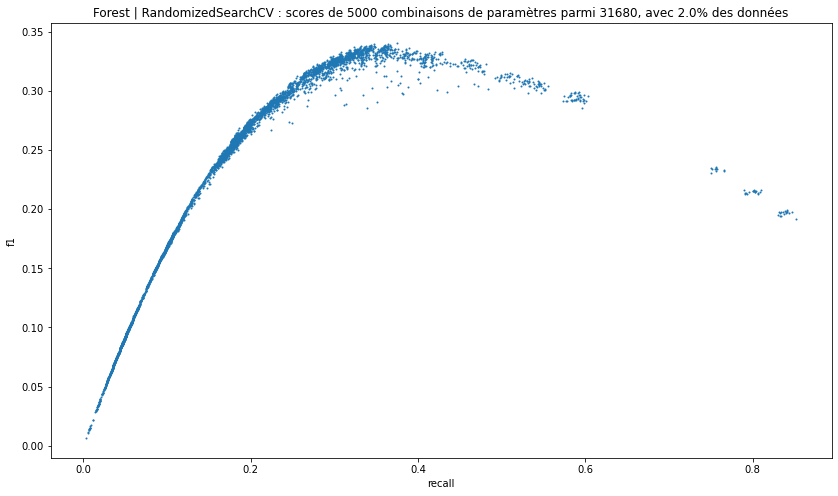

In [20]:
graph_2scores_CV(dico, results, 'recall', 'f1', s=1)

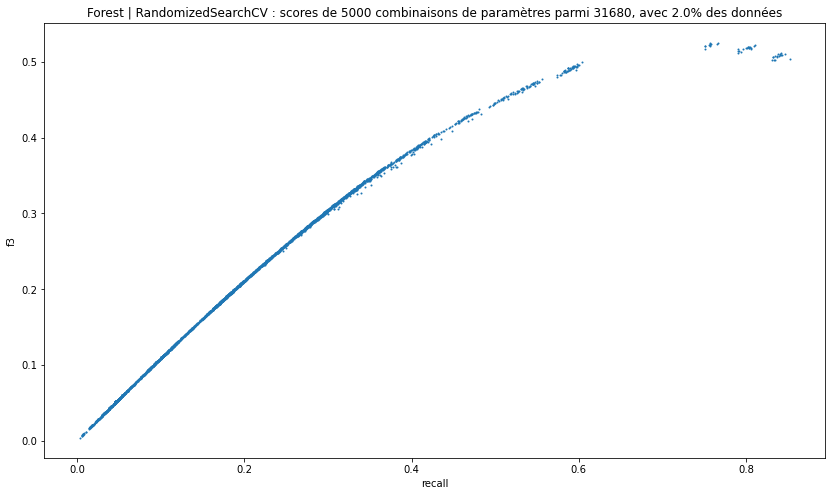

In [21]:
graph_2scores_CV(dico, results, 'recall', 'f3', s=1)

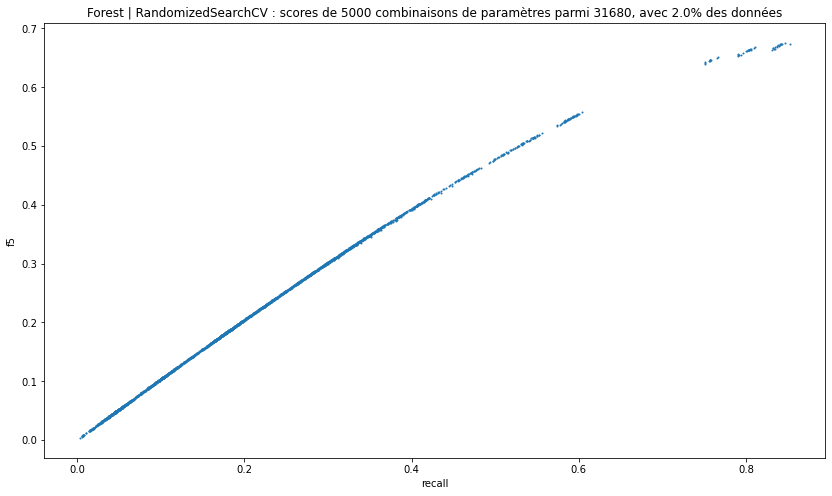

In [22]:
graph_2scores_CV(dico, results, 'recall', 'f5', s=1)

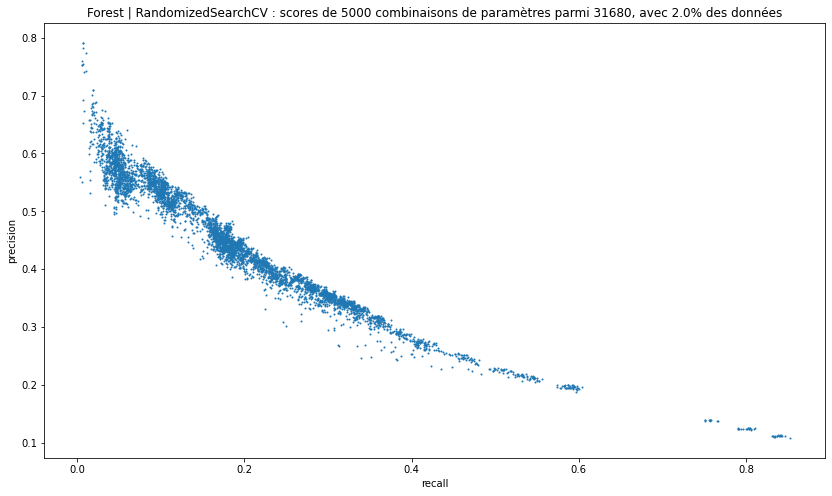

In [23]:
graph_2scores_CV(dico, results, 'recall', 'precision', s=1)

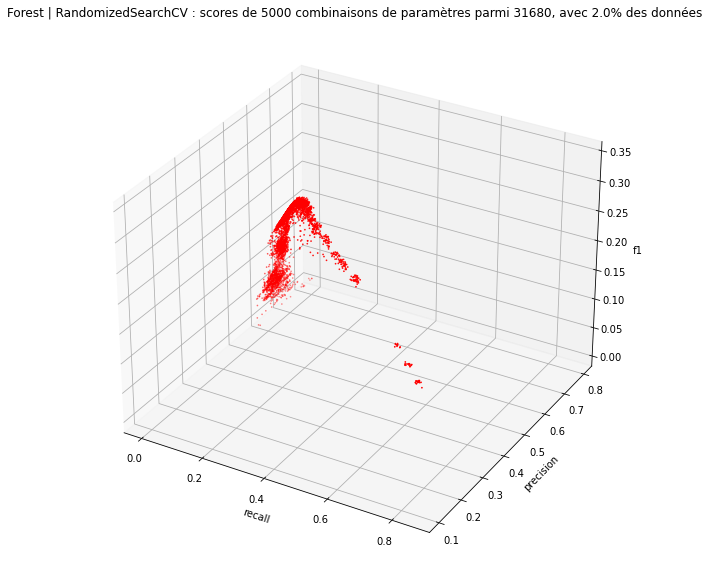

In [24]:
graph_3scores_CV(dico, results, 'recall', 'precision', 'f1', s=0.5)

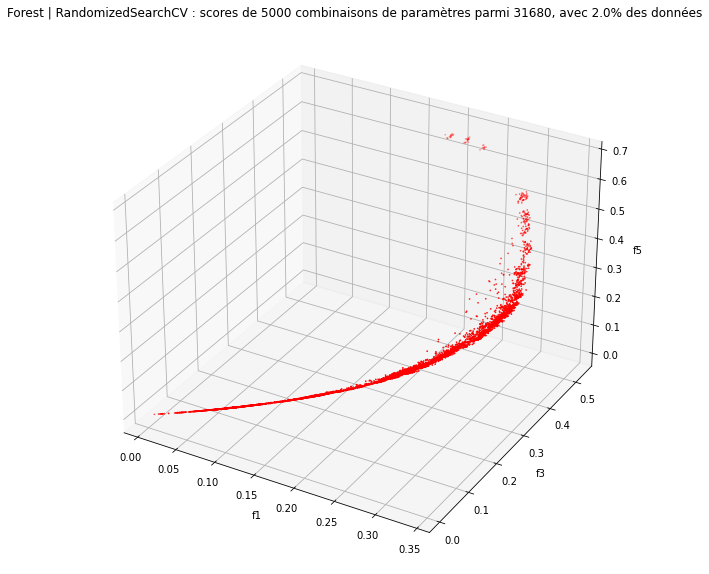

In [25]:
graph_3scores_CV(dico, results, 'f1', 'f3', 'f5', s=0.5)

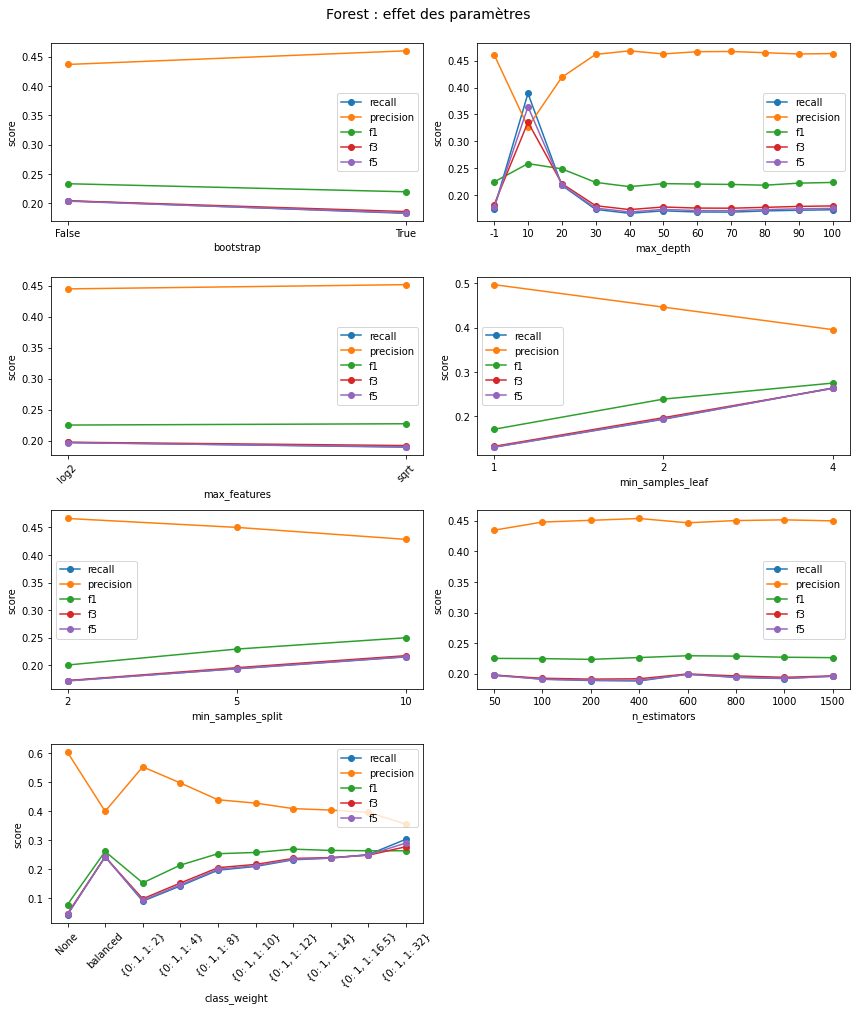

In [26]:
graph_param_CV(dico, results, ncols=2, height=3.5, width=6)

In [27]:
best_params = best_score_CV(dico, results, 'f3')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_class_weight,...,rank_test_precision,mean_test_f1,std_test_f1,rank_test_f1,mean_test_f3,std_test_f3,rank_test_f3,mean_test_f5,std_test_f5,rank_test_f5
1278,37.87703,0.357972,1.674242,0.03837,1500,2,4,sqrt,10,"{0: 1, 1: 32}",...,4963,0.232782,0.006456,2947,0.525351,0.015903,1,0.651352,0.021492,36
4550,37.798246,0.309513,1.707737,0.054846,1500,5,1,sqrt,10,"{0: 1, 1: 32}",...,4955,0.235862,0.006942,2908,0.524877,0.01791,2,0.64686,0.023929,38
1851,37.519424,0.112225,1.738546,0.060844,1500,5,4,sqrt,10,"{0: 1, 1: 32}",...,4964,0.231889,0.006234,2952,0.524234,0.016317,3,0.650447,0.022344,37
4703,2.512686,0.043452,0.130894,0.004717,100,2,2,sqrt,10,"{0: 1, 1: 32}",...,4960,0.234181,0.007708,2930,0.523611,0.016186,4,0.646613,0.020439,39
3475,37.643257,0.966817,1.658356,0.047024,1500,5,2,sqrt,10,"{0: 1, 1: 32}",...,4957,0.234484,0.007363,2927,0.523521,0.018484,5,0.64607,0.024305,40
2329,5.125927,0.083236,0.25046,0.015402,200,5,2,sqrt,10,"{0: 1, 1: 32}",...,4961,0.233668,0.006374,2938,0.522682,0.016647,6,0.645572,0.022574,41
1553,10.197965,0.16427,0.472824,0.007845,400,5,1,sqrt,10,"{0: 1, 1: 32}",...,4958,0.234162,0.007399,2931,0.522547,0.018297,7,0.644749,0.024139,43
990,1.810313,0.049651,0.077574,0.004073,50,2,2,sqrt,10,"{0: 1, 1: 32}",...,4968,0.215898,0.006817,3031,0.522405,0.012042,8,0.66848,0.014121,13
2527,38.272804,0.413294,1.72237,0.058261,1500,2,1,sqrt,10,"{0: 1, 1: 32}",...,4956,0.234922,0.006003,2921,0.521597,0.015597,9,0.642199,0.020971,44
1186,19.957523,0.193564,0.909535,0.034259,800,10,2,sqrt,10,"{0: 1, 1: 32}",...,4962,0.232378,0.006539,2948,0.521393,0.016688,10,0.644816,0.022402,42


Meilleure combinaison de paramètres pour f3 :


{'n_estimators': 1500,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'class_weight': {0: 1, 1: 32},
 'bootstrap': True}

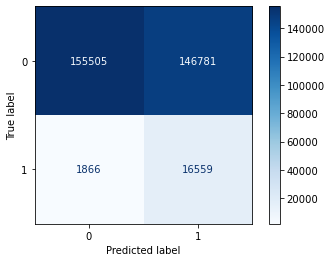

f1 : 0.1822
f3 : 0.5031
f5 : 0.6900
recall : 0.8987
negative predictive value : 0.9881
precision : 0.1014
roc_auc : 0.8240
training time : 1min, 3.667s
prediction time : 1.106s


In [28]:
best_params['n_estimators'] = 400
m = Modelisation(X, y, RandomForestClassifier(**best_params, n_jobs=-1))
m.show_conf_matrix()
m.show_metrics_score()

## Oversampling

In [29]:
over = RandomOverSampler(random_state=1234)

pipeline = Pipeline_imb([
            ('over', over),
            ('model', RandomForestClassifier())
            ])

cv_params = {
        "over__sampling_strategy": [0.1, 0.2, 0.4, 0.6, 0.8, 1],
        "model__bootstrap": [False, True],
        "model__max_depth": [10, 20, 30, 40, 50, 60, 80, 100, None],
        "model__max_features": ['sqrt', 'log2'],
        "model__min_samples_leaf": [1, 2, 4],
        "model__min_samples_split": [2, 5, 10],
        "model__n_estimators": [50, 100, 200, 400, 600, 800, 1000, 1500],
        "model__class_weight": [None, 'balanced', {0:1, 1:2}, {0:1, 1:4}, {0:1, 1:8}, {0:1, 1:10}, {0:1, 1:12}, {0:1, 1:14}, {0:1, 1:16.5}, {0:1, 1:32}] 
}

scoring = {'recall': 'recall',
           'precision': 'precision',
           'f1': 'f1',
           'f3': make_scorer(fbeta_score, beta=3),
           'f5': make_scorer(fbeta_score, beta=5)
          }

print(len(ParameterGrid(cv_params)))

155520


In [30]:
# SearchCV(pipeline, cv_params, data_frac=0.02, random=True, n_iter=5000, scoring=scoring, random_state=1234, n_jobs=28)

In [31]:
dico, results = restauration_CV('RandomOver_Forest_CV_Randomized5000_155520_0.02')

model : Pipeline(steps=[('over', RandomOverSampler(random_state=1234)),
                ('model', RandomForestClassifier())])
model_name : RandomOver_Forest
type : RandomizedSearchCV
len_grid : 155520
n_iter : 5000
data_frac : 0.02
temps : 10h, 15min, 32.211s
n_jobs : 28
params : {'over__sampling_strategy': [0.1, 0.2, 0.4, 0.6, 0.8, 1], 'model__bootstrap': [False, True], 'model__max_depth': [10, 20, 30, 40, 50, 60, 80, 100, None], 'model__max_features': ['sqrt', 'log2'], 'model__min_samples_leaf': [1, 2, 4], 'model__min_samples_split': [2, 5, 10], 'model__n_estimators': [50, 100, 200, 400, 600, 800, 1000, 1500], 'model__class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 1, 1: 4}, {0: 1, 1: 8}, {0: 1, 1: 10}, {0: 1, 1: 12}, {0: 1, 1: 14}, {0: 1, 1: 16.5}, {0: 1, 1: 32}]}
scoring : {'recall': 'recall', 'precision': 'precision', 'f1': 'f1', 'f3': make_scorer(fbeta_score, beta=3), 'f5': make_scorer(fbeta_score, beta=5)}


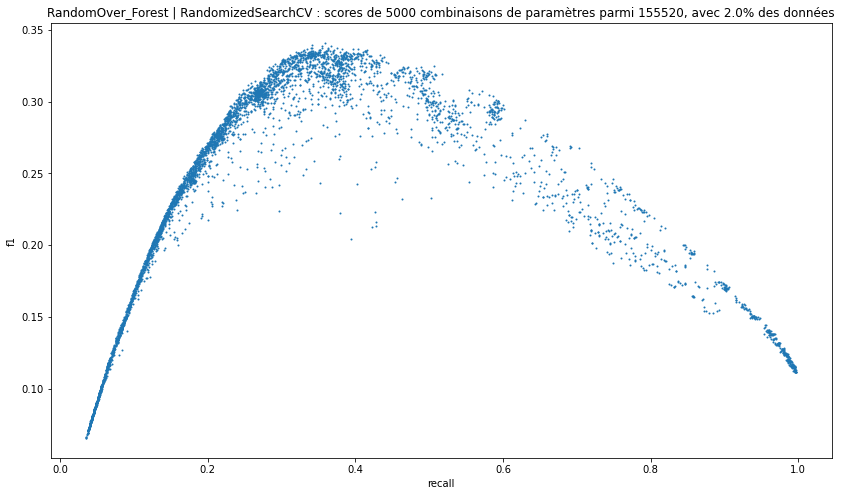

In [32]:
graph_2scores_CV(dico, results, 'recall', 'f1', s=1)

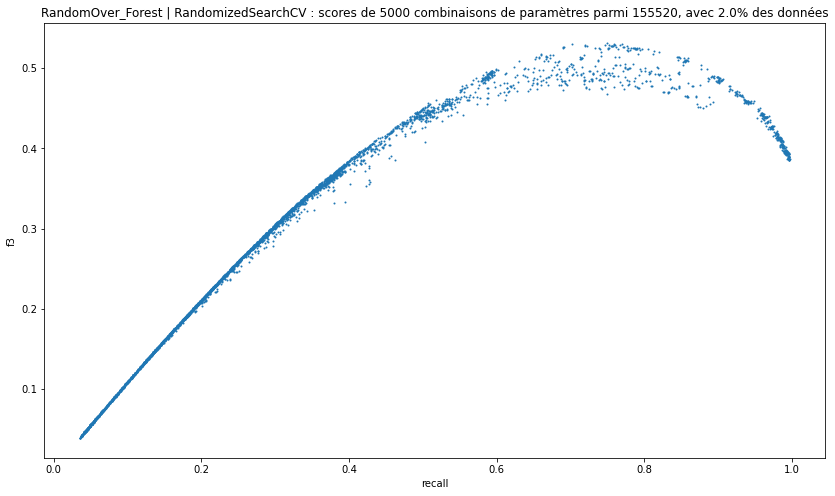

In [33]:
graph_2scores_CV(dico, results, 'recall', 'f3', s=1)

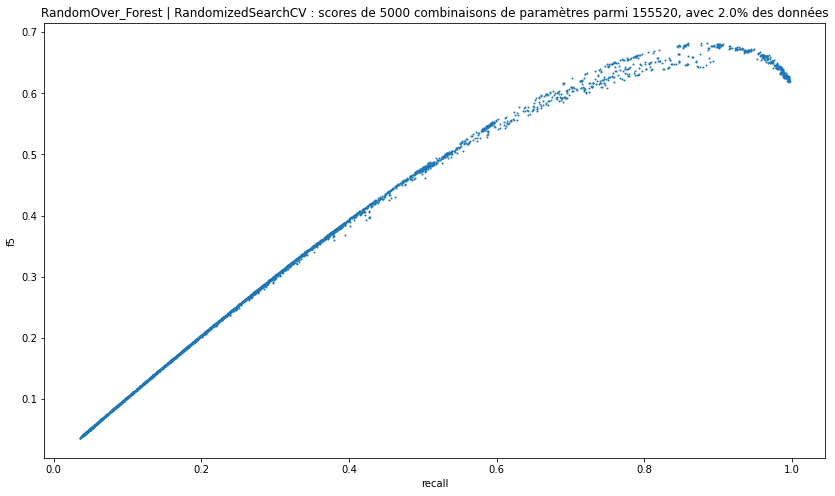

In [34]:
graph_2scores_CV(dico, results, 'recall', 'f5', s=1)

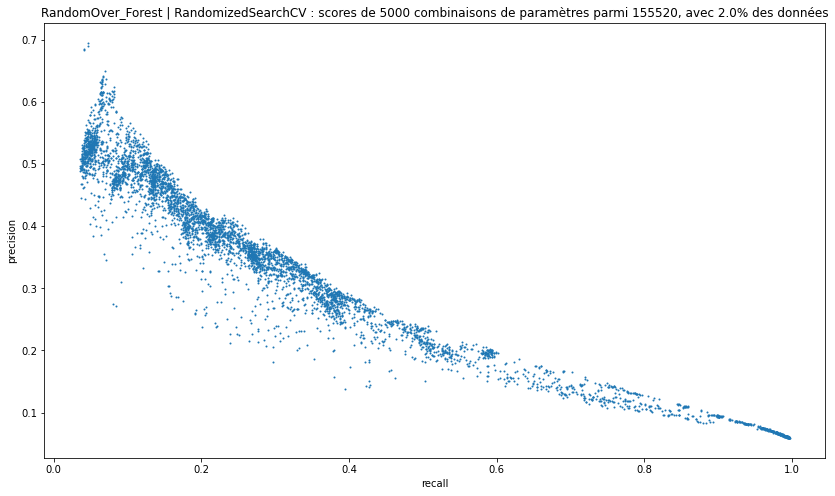

In [35]:
graph_2scores_CV(dico, results, 'recall', 'precision', s=1)

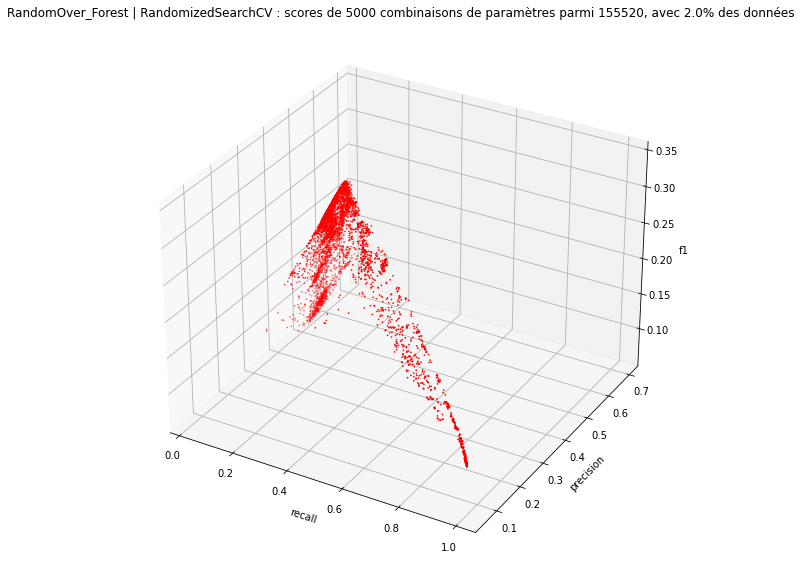

In [36]:
graph_3scores_CV(dico, results, 'recall', 'precision', 'f1', s=0.5)

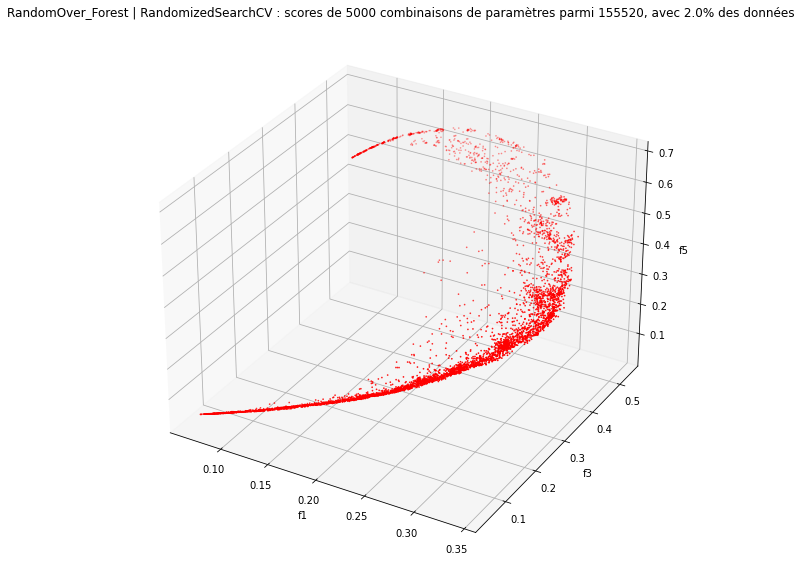

In [37]:
graph_3scores_CV(dico, results, 'f1', 'f3', 'f5', s=0.5)

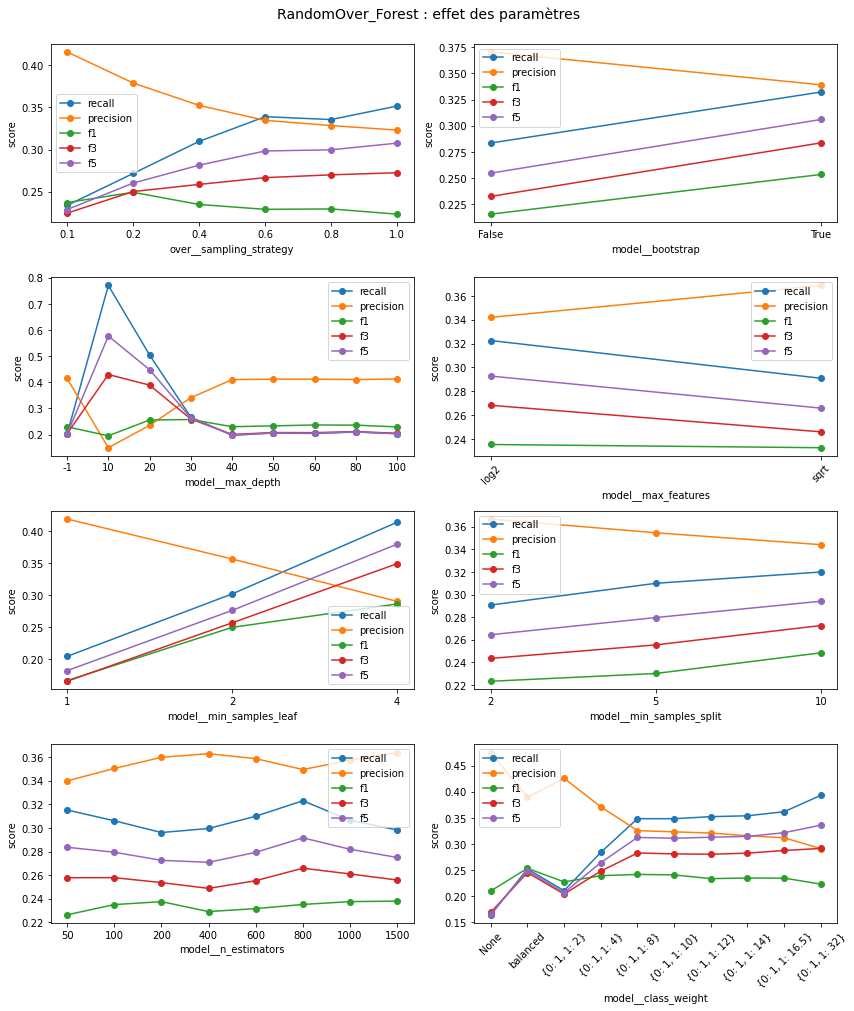

In [38]:
graph_param_CV(dico, results, ncols=2, height=3.5, width=6)

In [39]:
best_params = best_score_CV(dico, results, 'f3')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_over__sampling_strategy,param_model__n_estimators,param_model__min_samples_split,param_model__min_samples_leaf,param_model__max_features,param_model__max_depth,...,rank_test_precision,mean_test_f1,std_test_f1,rank_test_f1,mean_test_f3,std_test_f3,rank_test_f3,mean_test_f5,std_test_f5,rank_test_f5
4728,5.750929,0.054033,0.249863,0.003123,0.2,200,10,1,sqrt,10,...,4442,0.24588,0.005546,2582,0.531603,0.014445,1,0.647347,0.018946,243
3588,16.090187,0.503798,0.718247,0.052758,0.1,600,10,4,sqrt,10,...,4389,0.267963,0.004495,2201,0.530572,0.012794,2,0.624798,0.016927,437
3200,23.023226,2.143023,0.760088,0.178295,0.1,600,2,2,sqrt,10,...,4494,0.235891,0.004076,2787,0.530018,0.01124,3,0.655861,0.015685,172
370,47.486488,6.923606,1.319435,0.260128,0.8,1000,2,1,sqrt,10,...,4464,0.240343,0.005112,2705,0.529916,0.012472,4,0.65052,0.016472,219
617,35.813194,4.702919,0.892308,0.078622,0.8,800,10,1,sqrt,10,...,4479,0.239032,0.005771,2727,0.529271,0.012436,5,0.650873,0.015541,211
3419,22.034114,0.456468,0.676711,0.014693,0.1,600,10,1,sqrt,10,...,4408,0.257148,0.004412,2370,0.529108,0.012972,6,0.631969,0.017665,370
4673,59.457714,0.584888,1.1653,0.026864,0.8,1000,10,2,sqrt,10,...,4471,0.239348,0.006108,2721,0.528959,0.013444,7,0.649969,0.016888,224
1273,22.012906,0.494695,0.750562,0.109324,0.1,600,5,2,sqrt,10,...,4496,0.235561,0.004869,2794,0.528659,0.011621,8,0.653864,0.015793,187
627,34.586701,4.229109,1.107345,0.211067,0.4,800,2,2,sqrt,10,...,4457,0.241373,0.005704,2678,0.528602,0.010792,9,0.647091,0.013002,250
66,32.192443,3.488588,1.483541,0.374002,0.2,1000,2,4,sqrt,10,...,4449,0.243099,0.003941,2647,0.528122,0.011636,10,0.644376,0.016026,269


Meilleure combinaison de paramètres pour f3 :


{'over__sampling_strategy': 0.2,
 'model__n_estimators': 200,
 'model__min_samples_split': 10,
 'model__min_samples_leaf': 1,
 'model__max_features': 'sqrt',
 'model__max_depth': 10,
 'model__class_weight': {0: 1, 1: 8},
 'model__bootstrap': True}

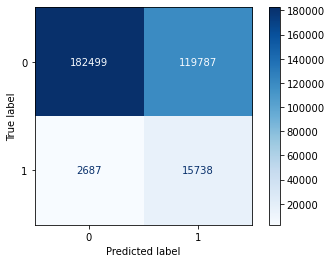

f1 : 0.2045
f3 : 0.5222
f5 : 0.6864
recall : 0.8542
negative predictive value : 0.9855
precision : 0.1161
roc_auc : 0.8235
training time : 42.251s
prediction time : 0.733s


In [40]:
best_params['model__n_jobs'] = -1
m = Modelisation(X, y, pipeline.set_params(**best_params), scaling=False)
m.show_conf_matrix()
m.show_metrics_score()

In [41]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Temps d'exécution total : 00:05:04
